# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
print(azdias.shape)
print(feat_info.shape)

(891221, 85)
(85, 4)


In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
#print(azdias.describe())
azdias.head()



AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...            NaN         NaN   
1                      4                 5    ...            2.0         3.0   
2                      3                 5    ...            3.0         3.0   
3                      1                 2    ...            2.0         2.0   
4                      3                 2    ...            2.0         4.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         NaN         NaN          NaN       NaN       NaN     NaN   
1         2.0         1.0          1.0       5.0       4.0     3.0   
2         1.0         0.0          1.0       4.0       4.0     3.0   
3         2.0         0.0          1.0       3.0       4.0     2.0   
4         2.0         1.0          2.0       3.0       3.0     4.0   

   ORTSGR_KLS9  RELAT_AB  
0          NaN       NaN  
1          5.0       4.0  
2          5.0       2.0  
3          3.0       3.0  
4          6.0       5.0  

[5 rows x 85 columns]

In [5]:
azdias.describe()



AGER_TYP  ALTERSKATEGORIE_GROB      ANREDE_KZ  CJT_GESAMTTYP  \
count  891221.000000         891221.000000  891221.000000  886367.000000   
mean       -0.358435              2.777398       1.522098       3.632838   
std         1.198724              1.068775       0.499512       1.595021   
min        -1.000000              1.000000       1.000000       1.000000   
25%        -1.000000              2.000000       1.000000       2.000000   
50%        -1.000000              3.000000       2.000000       4.000000   
75%        -1.000000              4.000000       2.000000       5.000000   
max         3.000000              9.000000       2.000000       6.000000   

       FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
count      891221.000000  891221.000000     891221.000000   891221.000000   
mean            3.074528       2.821039          3.401106        3.033328   
std             1.321055       1.464749          1.322134        1.529603   
min             1.000000       1.000000          1.000000        1.000000   
25%             2.000000       1.000000          3.000000        2.000000   
50%             3.000000       3.000000          3.000000        3.000000   
75%             4.000000       4.000000          5.000000        5.000000   
max             5.000000       5.000000          5.000000        5.000000   

       FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER      ...          PLZ8_ANTG1  \
count          891221.000000     891221.000000      ...       774706.000000   
mean                2.874167          3.075121      ...            2.253330   
std                 1.486731          1.353248      ...            0.972008   
min                 1.000000          1.000000      ...            0.000000   
25%                 2.000000          2.000000      ...            1.000000   
50%                 3.000000          3.000000      ...            2.000000   
75%                 4.000000          4.000000      ...            3.000000   
max                 5.000000          5.000000      ...            4.000000   

          PLZ8_ANTG2     PLZ8_ANTG3     PLZ8_ANTG4    PLZ8_BAUMAX  \
count  774706.000000  774706.000000  774706.000000  774706.000000   
mean        2.801858       1.595426       0.699166       1.943913   
std         0.920309       0.986736       0.727137       1.459654   
min         0.000000       0.000000       0.000000       1.000000   
25%         2.000000       1.000000       0.000000       1.000000   
50%         3.000000       2.000000       1.000000       1.000000   
75%         3.000000       2.000000       1.000000       3.000000   
max         4.000000       3.000000       2.000000       5.000000   

            PLZ8_HHZ       PLZ8_GBZ         ARBEIT    ORTSGR_KLS9  \
count  774706.000000  774706.000000  794005.000000  794005.000000   
mean        3.612821       3.381087       3.167854       5.293002   
std         0.973967       1.111598       1.002376       2.303739   
min         1.000000       1.000000       1.000000       0.000000   
25%         3.000000       3.000000       3.000000       4.000000   
50%         4.000000       3.000000       3.000000       5.000000   
75%         4.000000       4.000000       4.000000       7.000000   
max         5.000000       5.000000       9.000000       9.000000   

           RELAT_AB  
count  794005.00000  
mean        3.07222  
std         1.36298  
min         1.00000  
25%         2.00000  
50%         3.00000  
75%         4.00000  
max         9.00000  

[8 rows x 81 columns]

In [6]:
#print(feat_info.describe())
feat_info.head(10)

attribute information_level         type missing_or_unknown
0               AGER_TYP            person  categorical             [-1,0]
1   ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2              ANREDE_KZ            person  categorical             [-1,0]
3          CJT_GESAMTTYP            person  categorical                [0]
4      FINANZ_MINIMALIST            person      ordinal               [-1]
5          FINANZ_SPARER            person      ordinal               [-1]
6       FINANZ_VORSORGER            person      ordinal               [-1]
7         FINANZ_ANLEGER            person      ordinal               [-1]
8  FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9       FINANZ_HAUSBAUER            person      ordinal               [-1]

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions 
at the end of each step that has one!


<font color='green'>
from this function >> azdias.isnull().sum(),, all columns or features of the azdias dataset are returned with the number of missings.. However, the feat_info dataset contains a column, missing or unknown, which has a describtion or codes, characters that represnt missing data used in the azdias dataset,, </font>



#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:

#Let's identify naturally missing values (NaNs)
azdias_missing = azdias.isnull().sum()
azdias_missing_sum = sum(azdias_missing)
print(azdias_missing)
print(azdias_missing_sum)


AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [8]:
display(feat_info.missing_or_unknown)

0       [-1,0]
1     [-1,0,9]
2       [-1,0]
3          [0]
4         [-1]
5         [-1]
6         [-1]
7         [-1]
8         [-1]
9         [-1]
10        [-1]
11         [0]
12          []
13          []
14      [-1,0]
15         [0]
16         [0]
17         [0]
18         [0]
19         [0]
20         [0]
21      [-1,0]
22      [-1,0]
23         [0]
24      [-1,9]
25      [-1,9]
26      [-1,9]
27      [-1,9]
28      [-1,9]
29      [-1,9]
        ...   
55        [-1]
56        [-1]
57      [-1,X]
58        [XX]
59     [-1,XX]
60        [-1]
61        [-1]
62        [-1]
63        [-1]
64      [-1,0]
65      [-1,0]
66        [-1]
67        [-1]
68        [-1]
69          []
70      [-1,0]
71          []
72          []
73      [-1,0]
74          []
75        [-1]
76        [-1]
77        [-1]
78        [-1]
79      [-1,0]
80        [-1]
81        [-1]
82      [-1,9]
83      [-1,0]
84      [-1,9]
Name: missing_or_unknown, Length: 85, dtype: object

In [9]:
# cleansing feat_info
feat_info['missing_or_unknown'] = feat_info.missing_or_unknown.str.strip('[]').str.split(',')

# Identify missing or unknown data values and convert them to NaNs
for attrib, missing_values in zip(feat_info['attribute'],feat_info['missing_or_unknown']):
    if missing_values[0] != '':
        for value in missing_values:
            
            if value.isnumeric() or value.lstrip('-').isnumeric(): # to prevent converting XX or X
                value = int(value) 
            # convert
            azdias.loc[azdias[attrib]==value,attrib]=np.nan

#Save the result into a new df as this step takes a long time to run    
azdias.to_csv('azdias_parsed.csv', sep=';', index = False)

In [12]:
#not used code
#remove prackets
feat_missing = feat_info
feat_missing = feat_missing['missing_or_unknown'].str.strip('[]')

#display(feat_missing)
feat_missing.head()


#feat_missing2 = np.where(feat_missing=='X', 0, feat_missing)

#print(feat_missing2)

0      -1,0
1    -1,0,9
2      -1,0
3         0
4        -1
Name: missing_or_unknown, dtype: object

In [10]:
#display(feat_info)

display(azdias)


AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0            NaN                   2.0        1.0            2.0   
1            NaN                   1.0        2.0            5.0   
2            NaN                   3.0        2.0            3.0   
3            2.0                   4.0        2.0            2.0   
4            NaN                   3.0        1.0            5.0   
5            3.0                   1.0        2.0            2.0   
6            NaN                   2.0        2.0            5.0   
7            NaN                   1.0        1.0            3.0   
8            NaN                   3.0        1.0            3.0   
9            NaN                   3.0        2.0            4.0   
10           NaN                   3.0        2.0            1.0   
11           NaN                   2.0        1.0            6.0   
12           NaN                   3.0        1.0            6.0   
13           NaN                   1.0        2.0            5.0   
14           NaN                   3.0        1.0            6.0   
15           1.0                   4.0        2.0            4.0   
16           NaN                   1.0        2.0            1.0   
17           NaN                   2.0        1.0            6.0   
18           NaN                   2.0        2.0            6.0   
19           NaN                   3.0        1.0            3.0   
20           NaN                   2.0        2.0            4.0   
21           NaN                   2.0        1.0            3.0   
22           NaN                   1.0        1.0            4.0   
23           NaN                   3.0        1.0            3.0   
24           NaN                   3.0        2.0            6.0   
25           NaN                   1.0        1.0            3.0   
26           NaN                   3.0        1.0            3.0   
27           NaN                   3.0        1.0            4.0   
28           NaN                   3.0        1.0            2.0   
29           2.0                   4.0        2.0            1.0   
...          ...                   ...        ...            ...   
891191       1.0                   4.0        2.0            1.0   
891192       NaN                   1.0        2.0            3.0   
891193       2.0                   4.0        1.0            3.0   
891194       NaN                   3.0        1.0            4.0   
891195       2.0                   4.0        2.0            6.0   
891196       NaN                   2.0        2.0            6.0   
891197       NaN                   3.0        2.0            1.0   
891198       NaN                   3.0        1.0            5.0   
891199       NaN                   2.0        1.0            3.0   
891200       NaN                   1.0        2.0            3.0   
891201       NaN                   3.0        1.0            3.0   
891202       NaN                   2.0        2.0            5.0   
891203       NaN                   4.0        2.0            1.0   
891204       NaN                   3.0        1.0            5.0   
891205       1.0                   4.0        1.0            2.0   
891206       NaN                   1.0        2.0            4.0   
891207       1.0                   3.0        2.0            1.0   
891208       NaN                   4.0        1.0            2.0   
891209       NaN                   1.0        2.0            5.0   
891210       NaN                   3.0        1.0            5.0   
891211       NaN                   3.0        1.0            2.0   
891212       NaN                   4.0        1.0            1.0   
891213       NaN                   4.0        2.0            5.0   
891214       NaN                   1.0        2.0            4.0   
891215       NaN                   2.0        2.0            6.0   
891216       NaN                   3.0        2.0            5.0   
891217       NaN                   2.0        1.0            4.0

In [11]:
#not used code

# Identify missing or unknown data values and convert them to NaNs.

missing_az = azdias.isnull().sum().sum()
print(missing_az)

azdias_missing = azdias
azdias_missing[:] = azdias[:].replace('missing_or_unknown', np.NaN)
azdias_missing[:] = azdias[:].replace('missing', np.NaN)
azdias_missing[:] = azdias[:].replace('unknown', np.NaN)
azdias_missing[:] = azdias[:].replace(0, np.NaN)
azdias_missing[:] = azdias[:].replace(-1, np.NaN)
azdias_missing[:] = azdias[:].replace('X', np.NaN)
azdias_missing[:] = azdias[:].replace('XX', np.NaN)


missing_az2 = azdias_missing.isnull().sum().sum()
print(missing_az2)



8373929
13874352


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

<font color='green'>
same as before, missing data are identified by recognizing the Nans, and the presentage of missing values in each column is calculated then the hist function is used to visualize it. </font>

In [11]:
#feat_info.describe()
feat_info.head()

attribute information_level         type missing_or_unknown
0              AGER_TYP            person  categorical            [-1, 0]
1  ALTERSKATEGORIE_GROB            person      ordinal         [-1, 0, 9]
2             ANREDE_KZ            person  categorical            [-1, 0]
3         CJT_GESAMTTYP            person  categorical                [0]
4     FINANZ_MINIMALIST            person      ordinal               [-1]

In [12]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_az_per_column =(azdias.isnull().sum()/len(azdias))*100
print(missing_az_per_column)

print('HeLLooooo')
missing_fe_per_column =(feat_info.isnull().sum()/len(feat_info))*100 #for sure no data missing in here cuz features and their decsription
print(missing_fe_per_column)

AGER_TYP                 76.955435
ALTERSKATEGORIE_GROB      0.323264
ANREDE_KZ                 0.000000
CJT_GESAMTTYP             0.544646
FINANZ_MINIMALIST         0.000000
FINANZ_SPARER             0.000000
FINANZ_VORSORGER          0.000000
FINANZ_ANLEGER            0.000000
FINANZ_UNAUFFAELLIGER     0.000000
FINANZ_HAUSBAUER          0.000000
FINANZTYP                 0.000000
GEBURTSJAHR              44.020282
GFK_URLAUBERTYP           0.544646
GREEN_AVANTGARDE          0.000000
HEALTH_TYP               12.476816
LP_LEBENSPHASE_FEIN      10.954859
LP_LEBENSPHASE_GROB      10.611509
LP_FAMILIE_FEIN           8.728699
LP_FAMILIE_GROB           8.728699
LP_STATUS_FEIN            0.544646
LP_STATUS_GROB            0.544646
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
RETOURTYP_BK_S            0.544646
SEMIO_SOZ                 0.000000
SEMIO_FAM                 0.000000
SEMIO_REL                 0.000000
SEMIO_MAT                 0.000000
SEMIO_VERT          

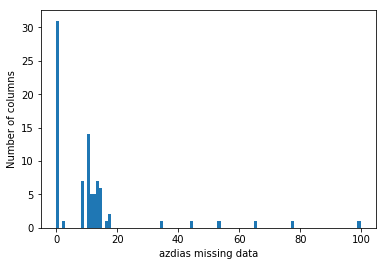

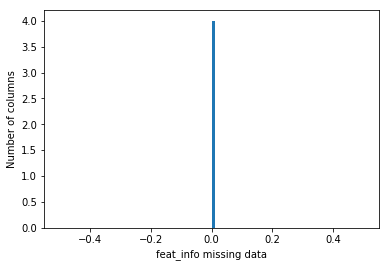

In [13]:
#missing data in each column

plt.hist(missing_az_per_column, bins=100)
plt.ylabel('Number of columns')
plt.xlabel('azdias missing data')
plt.show()


plt.hist(missing_fe_per_column, bins=100)   #here all should be 0
plt.ylabel('Number of columns')
plt.xlabel('feat_info missing data')
plt.show()

In [14]:
#divide dataset columns
missing_20_more = [col for col in azdias.columns if (missing_az_per_column[col] > 20)]
print(missing_20_more)
print('helloooooo')
missing_20_less = [col for col in azdias.columns if (missing_az_per_column[col] <= 20)]
print(missing_20_less)


['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
helloooooo
['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015

In [15]:
#here we delete columns that miss more than 20%
for col in missing_20_more:
    azdias.drop(col, axis=1, inplace=True)

In [16]:
print(azdias.columns) ##the new columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',
       'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
       'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
       'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015',
       'CAMEO

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

<font color='green'>
the previous step we calculated the persentage of missing data in each column.  then the azdias dataset is divided into 2 subsets based in the missing persentage in columns, the first subset contains the columns with less than 20% and the other with more than 20%. the columns used in the latter steps are the ones with less than 20% Nans. </font>

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

<font color='green'>
after dropping the columns which contain more than 20% of nulls, now we'll look at all the dataset rowsnand assess the missing data for each row, then the whole data will be visualized.. After that, the dataset will be divided based on the missing persentage of rows, 20% or more or less. </font> 

In [17]:
# How much data is missing in each row of the dataset?
missing_az_per_row = azdias.isnull().sum(axis=1)
missing_az_per_row = missing_az_per_row[missing_az_per_row > 0]/(len(azdias.columns)) * 100
missing_az_per_row.sort_values(inplace=True)

print(missing_az_per_row)



237075     1.265823
736043     1.265823
768679     1.265823
736038     1.265823
736034     1.265823
768704     1.265823
507723     1.265823
423777     1.265823
423798     1.265823
607469     1.265823
561377     1.265823
144760     1.265823
38612      1.265823
709002     1.265823
607433     1.265823
820005     1.265823
91916      1.265823
144785     1.265823
62924      1.265823
607405     1.265823
235445     1.265823
235435     1.265823
235434     1.265823
561427     1.265823
607271     1.265823
507663     1.265823
709042     1.265823
607245     1.265823
768647     1.265823
38561      1.265823
            ...    
604092    59.493671
604091    59.493671
348454    59.493671
146291    59.493671
768892    59.493671
62887     59.493671
604356    59.493671
146293    59.493671
604350    59.493671
604346    59.493671
604338    59.493671
604335    59.493671
62912     59.493671
275610    59.493671
275611    59.493671
604305    59.493671
275617    59.493671
604332    59.493671
275620    59.493671


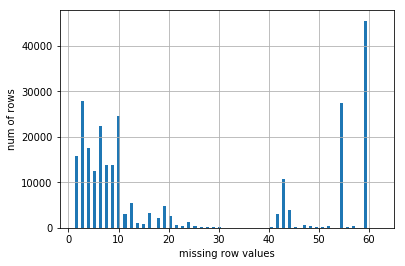

In [18]:
plt.hist(missing_az_per_row, bins=100)


plt.xlabel('missing row values')
plt.ylabel('num of rows')
plt.grid(True)
plt.show()

In [19]:
azdias['missing'] = missing_az_per_row

In [20]:
    
few_missing = azdias[azdias['missing'] <= 20]
high_missing = azdias[azdias['missing'] > 20]


In [21]:
few_missing = few_missing.drop('missing', 1)
high_missing = high_missing.drop('missing', 1)


In [22]:
col_names_few = few_missing.columns
print(col_names_few)


Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',
       'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
       'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
       'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015',
       'CAMEO

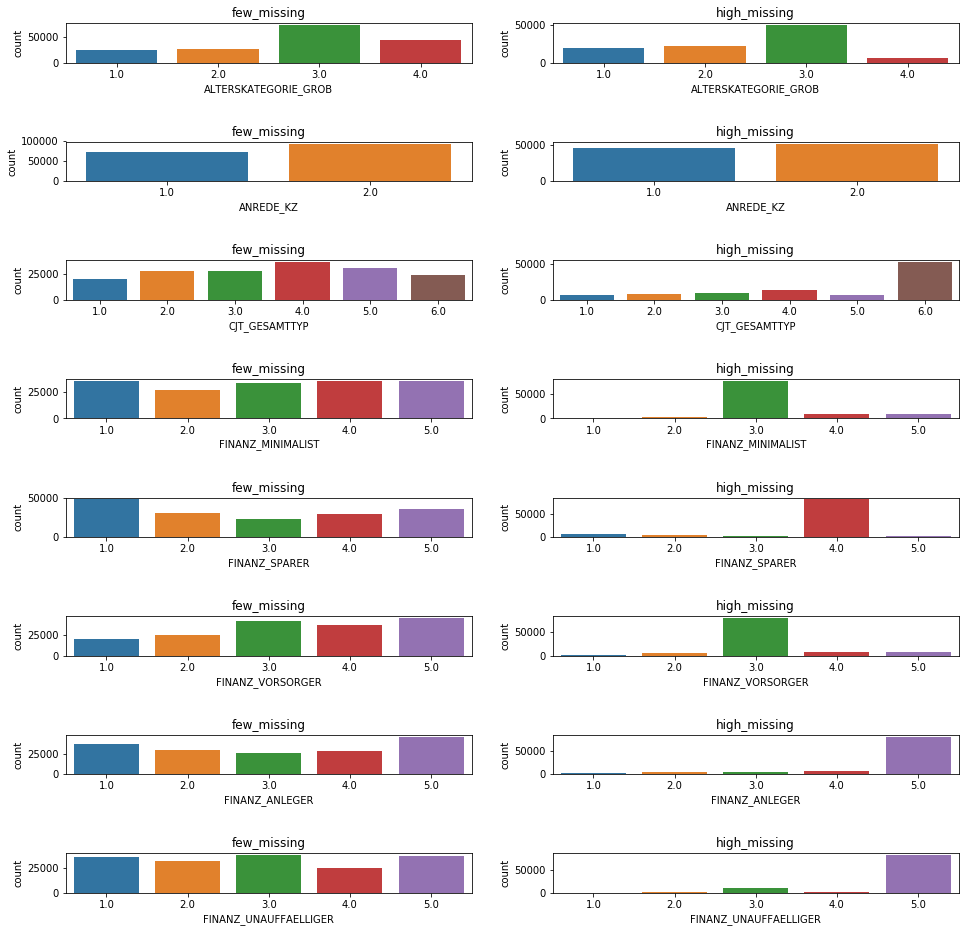

In [23]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.


def print_countplot(cols,num):
    
    fig, axs = plt.subplots(num,2, figsize=(16, 16))
    fig.subplots_adjust(hspace =2 , wspace=.2)
    axs = axs.ravel()

    for i in range(num):
        sns.countplot(few_missing[cols[i]], ax=axs[i*2])
        axs[i*2].set_title('few_missing')
        sns.countplot(high_missing[cols[i]], ax=axs[i*2+1])
        axs[i*2+1].set_title('high_missing')
    

print_countplot(col_names_few,8)



#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)
yes, there are a lot of missing values that should be removed to get a fair comparison.

<font color='green'>
    
from the visualization, the few missing data has close missig values, however, in the high missing, one specific feature contain a large valume of missing data.
</font>

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [24]:
# How many features are there of each data type?

print(feat_info['type'].value_counts())

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [25]:
print(col_names_few)
print(len(col_names_few))

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',
       'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
       'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
       'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015',
       'CAMEO

In [26]:
#find categorial features
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded? << those are 0,-1,X,9,XX

cat_feat = feat_info[feat_info['type'] == 'categorical']['attribute'].tolist()

print(cat_feat)



['AGER_TYP', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'KK_KUNDENTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [27]:
few_missing.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',
       'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
       'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
       'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015',
       'CAMEO

In [28]:
few_missing_categorial = []

for col in few_missing.columns:
    if col in cat_feat:
        print('hi')
        few_missing_categorial.append(col)
        print(few_missing.describe())
    


hi
       ALTERSKATEGORIE_GROB      ANREDE_KZ  CJT_GESAMTTYP  FINANZ_MINIMALIST  \
count         166338.000000  169078.000000  164710.000000      169078.000000   
mean               2.808444       1.558896       3.616951           3.052171   
std                0.988099       0.496521       1.590065           1.438189   
min                1.000000       1.000000       1.000000           1.000000   
25%                2.000000       1.000000       2.000000           2.000000   
50%                3.000000       2.000000       4.000000           3.000000   
75%                4.000000       2.000000       5.000000           4.000000   
max                4.000000       2.000000       6.000000           5.000000   

       FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
count  169078.000000     169078.000000   169078.000000          169078.000000   
mean        2.852790          3.373177        3.097405               2.970103   
std         1.535506          1.3

In [29]:
few_missing_categorial

['ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [30]:
few_missing.describe()

ALTERSKATEGORIE_GROB      ANREDE_KZ  CJT_GESAMTTYP  FINANZ_MINIMALIST  \
count         166338.000000  169078.000000  164710.000000      169078.000000   
mean               2.808444       1.558896       3.616951           3.052171   
std                0.988099       0.496521       1.590065           1.438189   
min                1.000000       1.000000       1.000000           1.000000   
25%                2.000000       1.000000       2.000000           2.000000   
50%                3.000000       2.000000       4.000000           3.000000   
75%                4.000000       2.000000       5.000000           4.000000   
max                4.000000       2.000000       6.000000           5.000000   

       FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
count  169078.000000     169078.000000   169078.000000          169078.000000   
mean        2.852790          3.373177        3.097405               2.970103   
std         1.535506          1.329412        1.530387               1.442093   
min         1.000000          1.000000        1.000000               1.000000   
25%         1.000000          2.000000        2.000000               2.000000   
50%         3.000000          3.000000        3.000000               3.000000   
75%         4.000000          5.000000        5.000000               4.000000   
max         5.000000          5.000000        5.000000               5.000000   

       FINANZ_HAUSBAUER      FINANZTYP      ...           PLZ8_ANTG1  \
count     169078.000000  169078.000000      ...        151125.000000   
mean           2.955932       3.401022      ...             2.352463   
std            1.531291       2.050270      ...             0.940895   
min            1.000000       1.000000      ...             0.000000   
25%            2.000000       1.000000      ...             2.000000   
50%            3.000000       3.000000      ...             2.000000   
75%            5.000000       6.000000      ...             3.000000   
max            5.000000       6.000000      ...             4.000000   

          PLZ8_ANTG2     PLZ8_ANTG3     PLZ8_ANTG4    PLZ8_BAUMAX  \
count  151125.000000  151125.000000  151125.000000  151125.000000   
mean        2.675878       1.446604       0.619937       1.773247   
std         0.921499       0.983481       0.702532       1.373596   
min         0.000000       0.000000       0.000000       1.000000   
25%         2.000000       1.000000       0.000000       1.000000   
50%         3.000000       1.000000       0.000000       1.000000   
75%         3.000000       2.000000       1.000000       2.000000   
max         4.000000       3.000000       2.000000       5.000000   

            PLZ8_HHZ       PLZ8_GBZ         ARBEIT    ORTSGR_KLS9  \
count  151125.000000  151125.000000  164913.000000  165007.000000   
mean        3.605373       3.506812       3.056108       4.931391   
std         1.025602       1.095534       1.024524       2.292738   
min         1.000000       1.000000       1.000000       1.000000   
25%         3.000000       3.000000       2.000000       3.000000   
50%         4.000000       3.000000       3.000000       5.000000   
75%         4.000000       4.000000       4.000000       7.000000   
max         5.000000       5.000000       5.000000       9.000000   

            RELAT_AB  
count  164913.000000  
mean        2.924724  
std         1.383978  
min         1.000000  
25%         2.000000  
50%         3.000000  
75%         4.000000  
max         5.000000  

[8 rows x 75 columns]

In [31]:
binary_features = []
multi_level_features=[]

for feature in few_missing_categorial:
    print('hh')
    if (len(few_missing[feature].unique())==2):
        binary_features.append(feature)
    elif (len(few_missing[feature].unique())>2):
        multi_level_features.append(feature)

hh
hh
hh
hh
hh
hh
hh
hh
hh
hh
hh
hh
hh
hh
hh
hh
hh
hh


In [32]:
print(binary_features) 
print(multi_level_features)

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ']
['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [33]:
multi_level_features
print(few_missing['SHOPPER_TYP'])



3         1.0
12        1.0
13        3.0
15        1.0
16        2.0
18        1.0
20        1.0
23        0.0
25        0.0
29        1.0
34        NaN
39        0.0
40        1.0
42        0.0
60        NaN
64        2.0
70        1.0
72        1.0
73        2.0
80        1.0
88        3.0
89        NaN
92        1.0
94        1.0
96        1.0
102       3.0
114       3.0
118       1.0
120       3.0
130       1.0
         ... 
891059    1.0
891069    2.0
891076    3.0
891077    2.0
891078    NaN
891079    1.0
891083    2.0
891104    0.0
891111    1.0
891112    1.0
891114    0.0
891115    2.0
891128    1.0
891129    NaN
891135    3.0
891136    0.0
891139    NaN
891150    1.0
891154    3.0
891155    NaN
891157    NaN
891161    1.0
891162    2.0
891181    3.0
891184    NaN
891203    1.0
891208    3.0
891216    3.0
891217    NaN
891218    2.0
Name: SHOPPER_TYP, Length: 169078, dtype: float64


In [34]:
# Re-encode categorical variable(s) to be kept in the analysis << from the features summary, i will choose the feAtures that aren't related to a person

few_missing['OST_WEST_KZ'].value_counts()



W    133858
O     35220
Name: OST_WEST_KZ, dtype: int64

In [35]:
new_values = {'W': 0, 'O': 1}
few_missing = few_missing.replace({'OST_WEST_KZ':new_values})

In [36]:
few_missing['ANREDE_KZ'].value_counts() 



2.0    94497
1.0    74581
Name: ANREDE_KZ, dtype: int64

In [37]:
few_missing['GREEN_AVANTGARDE'].value_counts() 



0    141014
1     28064
Name: GREEN_AVANTGARDE, dtype: int64

In [38]:
few_missing['SOHO_KZ'].value_counts() 




0.0    167711
1.0      1367
Name: SOHO_KZ, dtype: int64

In [39]:
multi_level_features

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?) 
 notes are written as comments
 
 
<font color='green'>
 
Re-encode categorical variable(s) to be kept in the analysis << from the features summary, i added the categorial features that exist in the few_features, here i encoded the OST_WEST_KZ to 0s and 1s, then the ANREDE_KZ and the other variables are already encoded!

   
 </font>

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [40]:
# Re-encode categorical variable(s) to be kept in the analysis << from the features summary, i will choose the feAtures that aren't related to a person

mixed_types = feat_info[feat_info['type'] == 'mixed']['attribute'].values
mixed_types = [x for x in mixed_types if x in few_missing.columns] # only the ones that are kept in few_missing dataset

In [41]:
print(mixed_types)

['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX']


In [44]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
few_missing.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',
       'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
       'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
       'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015',
       'CAMEO

In [45]:
few_missing['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    36898
8.0     25936
10.0    16456
5.0     14873
3.0      9512
15.0     8493
11.0     7073
1.0      5317
9.0      4482
12.0     4407
6.0      2827
4.0      2060
2.0      1281
13.0     1264
7.0       584
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [46]:
few_missing['Decade'] = few_missing['PRAEGENDE_JUGENDJAHRE'] #1st variable
few_missing['Movement'] = few_missing['PRAEGENDE_JUGENDJAHRE'] #2nd variable

In [47]:
#the numbers in the following dics are obtained from the dataDictonary file. also, based on  PRAEGENDE_JUGENDJAHRE
decade_dictionary = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
movement_dectionary = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0 ,8:1 ,9:0 ,10:1 ,11:0 ,12:1 ,13:0 ,14:1 ,15:0}


In [48]:
few_missing['Decade'].replace(decade_dictionary, inplace=True)
few_missing['Movement'].replace(movement_dectionary, inplace=True)

In [49]:
# delete original mixed column
few_missing=few_missing.drop('PRAEGENDE_JUGENDJAHRE',axis=1)


In [50]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

few_missing['CAMEO_INTL_2015'].value_counts()

51    22231
41    17433
24    16715
14    14100
23    11335
43     9957
22     9032
25     8444
54     7394
13     6545
31     6291
12     6236
55     5228
45     4013
52     3831
15     3335
34     3333
44     2716
33     2424
32     2233
35     1936
Name: CAMEO_INTL_2015, dtype: int64

In [51]:


few_missing['Wealth'] = few_missing['CAMEO_INTL_2015'] #1st variable
few_missing['Life Stage Typology'] = few_missing['CAMEO_INTL_2015'] #2nd variable


In [52]:
#the numbers in the following dics are obtained from the dataDictonary file. also, based on  CAMEO_INTL_2015
wealth_dictionary = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2, '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4, '51':5, '52':5, '53':5, '54':5, '55':5}
life_dictionary = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5, '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5, '51':1, '52':2, '53':3, '54':4, '55':5}


In [53]:
few_missing['Wealth'].replace(wealth_dictionary, inplace=True)
few_missing['Life Stage Typology'].replace(life_dictionary, inplace=True)

In [54]:
#delete original mixed column
few_missing=few_missing.drop('CAMEO_INTL_2015',axis=1)


In [56]:
mixed_types = feat_info[feat_info['type'] == 'mixed']['attribute'].values
mixed_types = [x for x in mixed_types if x in few_missing.columns] # only the ones that are kept in few_missing dataset

print(mixed_types) #delete the other mixed types

['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX']


In [57]:
few_missing=few_missing.drop('LP_LEBENSPHASE_FEIN',axis=1)




In [58]:
few_missing=few_missing.drop('LP_LEBENSPHASE_GROB',axis=1)
few_missing=few_missing.drop('WOHNLAGE',axis=1)
few_missing=few_missing.drop('PLZ8_BAUMAX',axis=1)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)
already written as comments in the code.

<font color='green'>
    as requested, 2 variables from the PRAEGENDE_JUGENDJAHRE are used (movement and decade), and to encode them, the dictionary file is used to assign their values,
similarly, CAMEO_INTL_2015, is replaced with 2 variables also that are related to it (wealth and life stage topology), and the values are obtained form the dictionary file. After creating the new columns, the original mixed columns are dropped from the dataset. Later on, the other mixed types columns are deleted using the drop (['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX'])
    </font>

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [59]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
#check if the few missing contains any missing values

#print(few_missing.columns)
#few_missing.head()
few_missing['Movement']
few_missing['Wealth']




3         1.0
12        4.0
13        3.0
15        4.0
16        4.0
18        2.0
20        2.0
23        4.0
25        3.0
29        1.0
34        2.0
39        NaN
40        NaN
42        2.0
60        5.0
64        5.0
70        2.0
72        3.0
73        4.0
80        2.0
88        1.0
89        4.0
92        2.0
94        4.0
96        5.0
102       2.0
114       2.0
118       4.0
120       1.0
130       4.0
         ... 
891059    2.0
891069    5.0
891076    2.0
891077    2.0
891078    4.0
891079    2.0
891083    2.0
891104    5.0
891111    5.0
891112    5.0
891114    2.0
891115    4.0
891128    4.0
891129    5.0
891135    5.0
891136    1.0
891139    5.0
891150    2.0
891154    4.0
891155    2.0
891157    3.0
891161    5.0
891162    4.0
891181    1.0
891184    5.0
891203    2.0
891208    1.0
891216    4.0
891217    5.0
891218    2.0
Name: Wealth, Length: 169078, dtype: float64

In [60]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.


In [61]:
from sklearn.preprocessing import OneHotEncoder


In [62]:
#hotOneEncoding to convert data into dummy variables #categorial variables
few_missing_dum = pd.get_dummies(few_missing)



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [63]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    df_missing= df.isnull().sum()
    print(df_missing)
    


    
    df_missing = df
    # cleansing feat_info
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
    
    feat_info['missing_or_unknown'] = feat_info.missing_or_unknown.str.strip('[]').str.split(',')

    # Identify missing or unknown data values and convert them to NaNs
    for attrib, missing_values in zip(feat_info['attribute'],feat_info['missing_or_unknown']):
        if missing_values[0] != '':
            for value in missing_values:
            
                if value.isnumeric() or value.lstrip('-').isnumeric(): # to prevent converting XX or X
                    value = int(value) 
            # convert
                df.loc[azdias[attrib]==value,attrib]=np.nan

    #Save the result into a new df as this step takes a long time to run    
    df.to_csv('azdias_parsed.csv', sep=';', index = False)
    
    missing_df_per_row = df.isnull().sum(axis=1)
    missing_df_per_row = missing_df_per_row[missing_df_per_row > 0]/(len(df.columns)) * 100
    
    df['missing'] = missing_df_per_row
    few_missing = df[df['missing'] <= 20]
    high_missing = df[df['missing'] > 20]
    few_missing = few_missing.drop('missing', 1)
    high_missing = high_missing.drop('missing', 1)
    
    col_names_few = few_missing.columns
    
    
    cat_feat = feat_info[feat_info['type'] == 'categorical']['attribute'].tolist()
    
    binary_features = []
    multi_level_features=[]

    few_missing_categorial = []

    for col in few_missing.columns:
        if col in cat_feat:
            few_missing_categorial.append(col)
    


    for feature in few_missing_categorial:
        if (len(few_missing[feature].unique())==2):
            binary_features.append(feature)
        elif (len(few_missing[feature].unique())>2):
            multi_level_features.append(feature)


        
    # Re-encode categorical variable(s) to be kept in the analysis << from the features summary, i will choose the feAtures that aren't related to a person

    new_values = {'W': 0, 'O': 1}
    few_missing = few_missing.replace({'OST_WEST_KZ':new_values})

    mixed_types = feat_info[feat_info['type'] == 'mixed']['attribute'].values
    mixed_types = [x for x in mixed_types if x in few_missing.columns] # only the ones that are kept in few_missing dataset

    # remove selected columns and rows, ...
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    few_missing.columns
    
    # select, re-encode, and engineer column values.
    few_missing['Decade'] = few_missing['PRAEGENDE_JUGENDJAHRE'] #1st variable
    few_missing['Movement'] = few_missing['PRAEGENDE_JUGENDJAHRE'] #2nd variable
    #the numbers in the following dics are obtained from the dataDictonary file. also, based on  PRAEGENDE_JUGENDJAHRE
    decade_dictionary = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    movement_dectionary = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0 ,8:1 ,9:0 ,10:1 ,11:0 ,12:1 ,13:0 ,14:1 ,15:0}
    few_missing['Decade'].replace(decade_dictionary, inplace=True)
    few_missing['Movement'].replace(movement_dectionary, inplace=True)
    few_missing=few_missing.drop('PRAEGENDE_JUGENDJAHRE',axis=1)

    
    few_missing['Wealth'] = few_missing['CAMEO_INTL_2015'] #1st variable
    few_missing['Life Stage Typology'] = few_missing['CAMEO_INTL_2015'] #2nd variable
    #the numbers in the following dics are obtained from the dataDictonary file. also, based on  CAMEO_INTL_2015
    wealth_dictionary = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2, '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4, '51':5, '52':5, '53':5, '54':5, '55':5}
    life_dictionary = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5, '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5, '51':1, '52':2, '53':3, '54':4, '55':5}
    few_missing['Wealth'].replace(wealth_dictionary, inplace=True)
    few_missing['Life Stage Typology'].replace(life_dictionary, inplace=True)
    few_missing=few_missing.drop('CAMEO_INTL_2015',axis=1)




    # delete original mixed column
    few_missing=few_missing.drop('LP_LEBENSPHASE_FEIN',axis=1)

    few_missing=few_missing.drop('LP_LEBENSPHASE_GROB',axis=1)
    few_missing=few_missing.drop('WOHNLAGE',axis=1)
    few_missing=few_missing.drop('PLZ8_BAUMAX',axis=1)
    
    #encode categorial
    
    few_missing_dum = pd.get_dummies(few_missing)



    
    # Return the cleaned dataframe.
    return few_missing_dum
    
    

In [64]:
def clean_data_1_test(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    df_missing= df.isnull().sum()
    print(df_missing)
    


    
    df_missing = df
    # cleansing feat_info
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
    
    feat_info['missing_or_unknown'] = feat_info.missing_or_unknown.str.strip('[]').str.split(',')

    # Identify missing or unknown data values and convert them to NaNs
    for attrib, missing_values in zip(feat_info['attribute'],feat_info['missing_or_unknown']):
        if missing_values[0] != '':
            for value in missing_values:
            
                if value.isnumeric() or value.lstrip('-').isnumeric(): # to prevent converting XX or X
                    value = int(value) 
            # convert
                df.loc[azdias[attrib]==value,attrib]=np.nan

    #Save the result into a new df as this step takes a long time to run    
    df.to_csv('azdias_parsed.csv', sep=';', index = False)
    
   

    
    # Return the cleaned dataframe.
    return df
    
    

In [66]:
def clean_data_2_test(df):

    missing_df_per_row = df.isnull().sum(axis=1)
    missing_df_per_row = missing_df_per_row[missing_df_per_row > 0]/(len(df.columns)) * 100
    
    df['missing'] = missing_df_per_row
    few_missing = df[df['missing'] <= 20]
    high_missing = df[df['missing'] > 20]
    few_missing = few_missing.drop('missing', 1)
    high_missing = high_missing.drop('missing', 1)
    
    col_names_few = few_missing.columns
    
    
    cat_feat = feat_info[feat_info['type'] == 'categorical']['attribute'].tolist()
    
    binary_features = []
    multi_level_features=[]

    few_missing_categorial = []

    for col in few_missing.columns:
        if col in cat_feat:
            few_missing_categorial.append(col)
    


    for feature in few_missing_categorial:
        if (len(few_missing[feature].unique())==2):
            binary_features.append(feature)
        elif (len(few_missing[feature].unique())>2):
            multi_level_features.append(feature)


        
    # Re-encode categorical variable(s) to be kept in the analysis << from the features summary, i will choose the feAtures that aren't related to a person

    new_values = {'W': 0, 'O': 1}
    few_missing = few_missing.replace({'OST_WEST_KZ':new_values})

    mixed_types = feat_info[feat_info['type'] == 'mixed']['attribute'].values
    mixed_types = [x for x in mixed_types if x in few_missing.columns] # only the ones that are kept in few_missing dataset

    # remove selected columns and rows, ...
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    few_missing.columns
    
    # select, re-encode, and engineer column values.
    few_missing['Decade'] = few_missing['PRAEGENDE_JUGENDJAHRE'] #1st variable
    few_missing['Movement'] = few_missing['PRAEGENDE_JUGENDJAHRE'] #2nd variable
    #the numbers in the following dics are obtained from the dataDictonary file. also, based on  PRAEGENDE_JUGENDJAHRE
    decade_dictionary = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    movement_dectionary = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0 ,8:1 ,9:0 ,10:1 ,11:0 ,12:1 ,13:0 ,14:1 ,15:0}
    few_missing['Decade'].replace(decade_dictionary, inplace=True)
    few_missing['Movement'].replace(movement_dectionary, inplace=True)
    few_missing=few_missing.drop('PRAEGENDE_JUGENDJAHRE',axis=1)

    
    few_missing['Wealth'] = few_missing['CAMEO_INTL_2015'] #1st variable
    few_missing['Life Stage Typology'] = few_missing['CAMEO_INTL_2015'] #2nd variable
    #the numbers in the following dics are obtained from the dataDictonary file. also, based on  CAMEO_INTL_2015
    wealth_dictionary = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2, '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4, '51':5, '52':5, '53':5, '54':5, '55':5}
    life_dictionary = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5, '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5, '51':1, '52':2, '53':3, '54':4, '55':5}
    few_missing['Wealth'].replace(wealth_dictionary, inplace=True)
    few_missing['Life Stage Typology'].replace(life_dictionary, inplace=True)
    few_missing=few_missing.drop('CAMEO_INTL_2015',axis=1)




    # delete original mixed column
    few_missing=few_missing.drop('LP_LEBENSPHASE_FEIN',axis=1)

    few_missing=few_missing.drop('LP_LEBENSPHASE_GROB',axis=1)
    few_missing=few_missing.drop('WOHNLAGE',axis=1)
    few_missing=few_missing.drop('PLZ8_BAUMAX',axis=1)
    
    #encode categorial
    
    few_missing_dum = pd.get_dummies(few_missing)



    
    # Return the cleaned dataframe.
    return few_missing_dum



In [67]:
display(few_missing.head (n=10))


ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  FINANZ_MINIMALIST  \
3                    4.0        2.0            2.0                4.0   
12                   3.0        1.0            6.0                5.0   
13                   1.0        2.0            5.0                1.0   
15                   4.0        2.0            4.0                4.0   
16                   1.0        2.0            1.0                4.0   
18                   2.0        2.0            6.0                2.0   
20                   2.0        2.0            4.0                4.0   
23                   3.0        1.0            3.0                5.0   
25                   1.0        1.0            3.0                3.0   
29                   4.0        2.0            1.0                5.0   

    FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
3             2.0               5.0             2.0                    1.0   
12            3.0               4.0             2.0                    4.0   
13            4.0               3.0             5.0                    5.0   
15            1.0               5.0             1.0                    1.0   
16            3.0               1.0             4.0                    5.0   
18            4.0               1.0             5.0                    4.0   
20            3.0               1.0             4.0                    5.0   
23            3.0               3.0             2.0                    2.0   
25            5.0               3.0             5.0                    4.0   
29            1.0               5.0             2.0                    1.0   

    FINANZ_HAUSBAUER  FINANZTYP         ...           PLZ8_ANTG4  PLZ8_HHZ  \
3                2.0        6.0         ...                  0.0       3.0   
12               1.0        3.0         ...                  0.0       5.0   
13               2.0        1.0         ...                  1.0       3.0   
15               4.0        2.0         ...                  NaN       NaN   
16               1.0        3.0         ...                  0.0       3.0   
18               1.0        1.0         ...                  1.0       3.0   
20               1.0        3.0         ...                  NaN       NaN   
23               1.0        6.0         ...                  NaN       NaN   
25               3.0        4.0         ...                  0.0       4.0   
29               3.0        6.0         ...                  0.0       3.0   

    PLZ8_GBZ  ARBEIT  ORTSGR_KLS9  RELAT_AB  Decade  Movement  Wealth  \
3        4.0     2.0          3.0       3.0     4.0       1.0     1.0   
12       5.0     3.0          6.0       4.0     4.0       1.0     4.0   
13       3.0     3.0          6.0       4.0     6.0       0.0     3.0   
15       NaN     4.0          8.0       5.0     3.0       1.0     4.0   
16       4.0     1.0          2.0       1.0     6.0       1.0     4.0   
18       3.0     3.0          4.0       3.0     5.0       1.0     2.0   
20       NaN     3.0          4.0       1.0     5.0       0.0     2.0   
23       NaN     3.0          6.0       2.0     4.0       0.0     4.0   
25       5.0     3.0          2.0       5.0     6.0       1.0     3.0   
29       4.0     2.0          4.0       3.0     3.0       0.0     1.0   

    Life Stage Typology  
3                   2.0  
12                  3.0  
13                  3.0  
15                  1.0  
16                  1.0  
18                  4.0  
20                  4.0  
23                  3.0  
25                  3.0  
29                  2.0  

[10 rows x 77 columns]

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [68]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
few_missing_dum.shape


(169078, 128)

In [69]:
few_missing_backup = few_missing_dum

In [70]:
from sklearn.preprocessing import Imputer


imp = Imputer(strategy='most_frequent')
data_imputed = pd.DataFrame(imp.fit_transform(few_missing_dum))



In [71]:
data_imputed.describe()

0              1              2              3    \
count  169078.000000  169078.000000  169078.000000  169078.000000   
mean        2.811549       1.558896       3.626847       3.052171   
std         0.980358       0.496521       1.570567       1.438189   
min         1.000000       1.000000       1.000000       1.000000   
25%         2.000000       1.000000       2.000000       2.000000   
50%         3.000000       2.000000       4.000000       3.000000   
75%         4.000000       2.000000       5.000000       4.000000   
max         4.000000       2.000000       6.000000       5.000000   

                 4              5              6              7    \
count  169078.000000  169078.000000  169078.000000  169078.000000   
mean        2.852790       3.373177       3.097405       2.970103   
std         1.535506       1.329412       1.530387       1.442093   
min         1.000000       1.000000       1.000000       1.000000   
25%         1.000000       2.000000       2.000000       2.000000   
50%         3.000000       3.000000       3.000000       3.000000   
75%         4.000000       5.000000       5.000000       4.000000   
max         5.000000       5.000000       5.000000       5.000000   

                 8              9        ...                  118  \
count  169078.000000  169078.000000      ...        169078.000000   
mean        2.955932       3.401022      ...             0.004536   
std         1.531291       2.050270      ...             0.067200   
min         1.000000       1.000000      ...             0.000000   
25%         2.000000       1.000000      ...             0.000000   
50%         3.000000       3.000000      ...             0.000000   
75%         5.000000       6.000000      ...             0.000000   
max         5.000000       6.000000      ...             1.000000   

                 119            120           121            122  \
count  169078.000000  169078.000000  169078.00000  169078.000000   
mean        0.048149       0.032222       0.02487       0.014632   
std         0.214082       0.176589       0.15573       0.120076   
min         0.000000       0.000000       0.00000       0.000000   
25%         0.000000       0.000000       0.00000       0.000000   
50%         0.000000       0.000000       0.00000       0.000000   
75%         0.000000       0.000000       0.00000       0.000000   
max         1.000000       1.000000       1.00000       1.000000   

                 123            124            125            126  \
count  169078.000000  169078.000000  169078.000000  169078.000000   
mean        0.022658       0.025988       0.025615       0.031731   
std         0.148812       0.159100       0.157985       0.175283   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

                 127  
count  169078.000000  
mean        0.016288  
std         0.126582  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000  

[8 rows x 128 columns]

In [72]:
from sklearn.preprocessing import StandardScaler




df_ss = StandardScaler().fit_transform(data_imputed) # Fit and transform the data



### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)
<font color=green>
    the imputer is used to have a clean data without nans, then the data is normalized using the SandardScalar function.
</font>

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [73]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

pca = PCA()
azdias_pca = pca.fit_transform(df_ss)

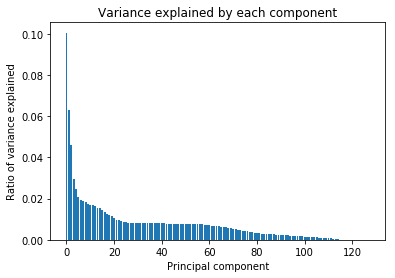

In [74]:
# Investigate the variance accounted for by each principal component.


plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.title("Variance explained by each component")
plt.xlabel("Principal component")
plt.ylabel("Ratio of variance explained")
plt.show()

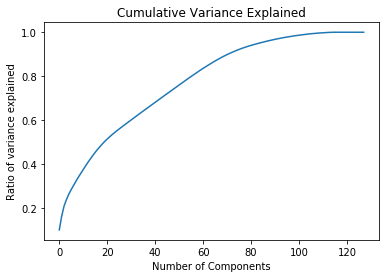

In [76]:
plt.plot(range(len(pca.explained_variance_ratio_)),np.cumsum(pca.explained_variance_ratio_), '-')
plt.title("Cumulative Variance Explained")
plt.xlabel("Number of Components")
plt.ylabel("Ratio of variance explained")
plt.show()

In [85]:
# Re-apply PCA to the data while selecting for number of components to retain.
new_pca = PCA(n_components=60)
azdias_pca = new_pca.fit_transform(df_ss)


### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)
<font color = green> here the pca is used to reduce the dimentiality of the dataset to have a faster machine learning algo, from the visualization, it can be observed that 60 components retains more than 80 ratio of variance, which is considered to be good, to have better accuracy with slower is better than low accuracy with fast. so 60 is average.. 
    </font>

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [86]:
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

import operator

def pca_weights_func(pca, i):
    weight_map = {}
    for counter, feature in enumerate(few_missing.columns):
        weight_map[feature] = pca.components_[i][counter]
    
    weights = sorted(weight_map.items(), key=operator.itemgetter(1), reverse=True)
    
    return weights


In [87]:
# Map weights for the first principal component to corresponding feature names
map_weights_1 = pca_weights_func(new_pca, 1)
print(map_weights_1)




[('FINANZ_VORSORGER', 0.26953236206993908), ('ALTERSKATEGORIE_GROB', 0.26126461754434349), ('SEMIO_ERL', 0.19142153935702297), ('SEMIO_LUST', 0.16062773890041931), ('FINANZ_MINIMALIST', 0.15803744564046862), ('RETOURTYP_BK_S', 0.14606468089641952), ('FINANZTYP', 0.14327138168851389), ('SHOPPER_TYP', 0.1122845591299329), ('W_KEIT_KIND_HH', 0.10545501884829836), ('SEMIO_KAEM', 0.072176125464780957), ('VERS_TYP', 0.065378887711906891), ('SEMIO_KRIT', 0.062889435123880469), ('Movement', 0.062580943483135018), ('WOHNDAUER_2008', 0.059359117100307897), ('ANREDE_KZ', 0.054503252426000792), ('LP_STATUS_GROB', 0.048698968675056971), ('FINANZ_HAUSBAUER', 0.045844834317007831), ('SEMIO_DOM', 0.040212567891395927), ('KBA05_ANTG2', 0.036803856311844831), ('LP_STATUS_FEIN', 0.036575263499282779), ('ANZ_HAUSHALTE_AKTIV', 0.029405451762730444), ('ANZ_HH_TITEL', 0.025617241574953209), ('PLZ8_HHZ', 0.019285453003772057), ('CAMEO_DEUG_2015', 0.017848886890833787), ('OST_WEST_KZ', 0.017315258460227145), (

In [88]:
import pprint
pprint.pprint(map_weights_1)


[('FINANZ_VORSORGER', 0.26953236206993908),
 ('ALTERSKATEGORIE_GROB', 0.26126461754434349),
 ('SEMIO_ERL', 0.19142153935702297),
 ('SEMIO_LUST', 0.16062773890041931),
 ('FINANZ_MINIMALIST', 0.15803744564046862),
 ('RETOURTYP_BK_S', 0.14606468089641952),
 ('FINANZTYP', 0.14327138168851389),
 ('SHOPPER_TYP', 0.1122845591299329),
 ('W_KEIT_KIND_HH', 0.10545501884829836),
 ('SEMIO_KAEM', 0.072176125464780957),
 ('VERS_TYP', 0.065378887711906891),
 ('SEMIO_KRIT', 0.062889435123880469),
 ('Movement', 0.062580943483135018),
 ('WOHNDAUER_2008', 0.059359117100307897),
 ('ANREDE_KZ', 0.054503252426000792),
 ('LP_STATUS_GROB', 0.048698968675056971),
 ('FINANZ_HAUSBAUER', 0.045844834317007831),
 ('SEMIO_DOM', 0.040212567891395927),
 ('KBA05_ANTG2', 0.036803856311844831),
 ('LP_STATUS_FEIN', 0.036575263499282779),
 ('ANZ_HAUSHALTE_AKTIV', 0.029405451762730444),
 ('ANZ_HH_TITEL', 0.025617241574953209),
 ('PLZ8_HHZ', 0.019285453003772057),
 ('CAMEO_DEUG_2015', 0.017848886890833787),
 ('OST_WEST_KZ', 

In [89]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

map_weights_2 = pca_weights_func(new_pca, 2)
print(map_weights_2)

[('SEMIO_VERT', 0.32489198509144995), ('SEMIO_FAM', 0.26355638822304095), ('SEMIO_KULT', 0.26353693000275158), ('SEMIO_SOZ', 0.25852876492028409), ('FINANZ_MINIMALIST', 0.12979678572572148), ('FINANZTYP', 0.11547092229511992), ('SEMIO_MAT', 0.10824518081788032), ('SEMIO_REL', 0.082173877931508377), ('FINANZ_VORSORGER', 0.077194475125526796), ('W_KEIT_KIND_HH', 0.075104694843850323), ('RETOURTYP_BK_S', 0.068040809079710579), ('Decade', 0.045508523756689172), ('PLZ8_HHZ', 0.043960257553295801), ('PLZ8_ANTG1', 0.042762782155883486), ('PLZ8_ANTG2', 0.041421287049342441), ('PLZ8_GBZ', 0.035374376691861283), ('ARBEIT', 0.033192812391639667), ('OST_WEST_KZ', 0.031952891666279848), ('KBA05_GBZ', 0.030809913393464131), ('ALTERSKATEGORIE_GROB', 0.030520139400682045), ('KBA13_ANZAHL_PKW', 0.029846316304058391), ('LP_STATUS_GROB', 0.027049603671422482), ('KBA05_ANTG2', 0.025205183674491427), ('LP_STATUS_FEIN', 0.02190540857762218), ('KBA05_ANTG1', 0.021585703810456054), ('ANZ_HAUSHALTE_AKTIV', 0.0

In [90]:
pprint.pprint(map_weights_2)



[('SEMIO_VERT', 0.32489198509144995),
 ('SEMIO_FAM', 0.26355638822304095),
 ('SEMIO_KULT', 0.26353693000275158),
 ('SEMIO_SOZ', 0.25852876492028409),
 ('FINANZ_MINIMALIST', 0.12979678572572148),
 ('FINANZTYP', 0.11547092229511992),
 ('SEMIO_MAT', 0.10824518081788032),
 ('SEMIO_REL', 0.082173877931508377),
 ('FINANZ_VORSORGER', 0.077194475125526796),
 ('W_KEIT_KIND_HH', 0.075104694843850323),
 ('RETOURTYP_BK_S', 0.068040809079710579),
 ('Decade', 0.045508523756689172),
 ('PLZ8_HHZ', 0.043960257553295801),
 ('PLZ8_ANTG1', 0.042762782155883486),
 ('PLZ8_ANTG2', 0.041421287049342441),
 ('PLZ8_GBZ', 0.035374376691861283),
 ('ARBEIT', 0.033192812391639667),
 ('OST_WEST_KZ', 0.031952891666279848),
 ('KBA05_GBZ', 0.030809913393464131),
 ('ALTERSKATEGORIE_GROB', 0.030520139400682045),
 ('KBA13_ANZAHL_PKW', 0.029846316304058391),
 ('LP_STATUS_GROB', 0.027049603671422482),
 ('KBA05_ANTG2', 0.025205183674491427),
 ('LP_STATUS_FEIN', 0.02190540857762218),
 ('KBA05_ANTG1', 0.021585703810456054),
 ('

In [91]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

map_weights_3 = pca_weights_func(new_pca, 3)
print(map_weights_3)

[('GREEN_AVANTGARDE', 0.28654368663998225), ('KBA05_GBZ', 0.25857883240586194), ('PLZ8_GBZ', 0.25747047430565795), ('LP_FAMILIE_GROB', 0.19842719140281559), ('LP_FAMILIE_FEIN', 0.19399131123889687), ('ANZ_PERSONEN', 0.17464925392287314), ('KKK', 0.15484232647303714), ('LP_STATUS_GROB', 0.14478963425960226), ('PLZ8_ANTG1', 0.1437458768936638), ('MIN_GEBAEUDEJAHR', 0.13711341887087306), ('PLZ8_ANTG2', 0.12907608465864084), ('ARBEIT', 0.12104744985254477), ('LP_STATUS_FEIN', 0.11774261538056284), ('KBA13_ANZAHL_PKW', 0.1141708294600406), ('PLZ8_HHZ', 0.098497009651637546), ('FINANZ_MINIMALIST', 0.096022886842337188), ('Wealth', 0.095416027152832206), ('PLZ8_ANTG3', 0.089198304859832794), ('SHOPPER_TYP', 0.082701716983009821), ('SEMIO_KAEM', 0.073060313421566284), ('KBA05_ANTG3', 0.053675346119735831), ('CJT_GESAMTTYP', 0.052775358956549619), ('SEMIO_DOM', 0.046649040471440008), ('Life Stage Typology', 0.045410599135093543), ('FINANZ_UNAUFFAELLIGER', 0.044080063195807248), ('ANZ_HH_TITEL',

In [92]:
pprint.pprint(map_weights_3)



[('GREEN_AVANTGARDE', 0.28654368663998225),
 ('KBA05_GBZ', 0.25857883240586194),
 ('PLZ8_GBZ', 0.25747047430565795),
 ('LP_FAMILIE_GROB', 0.19842719140281559),
 ('LP_FAMILIE_FEIN', 0.19399131123889687),
 ('ANZ_PERSONEN', 0.17464925392287314),
 ('KKK', 0.15484232647303714),
 ('LP_STATUS_GROB', 0.14478963425960226),
 ('PLZ8_ANTG1', 0.1437458768936638),
 ('MIN_GEBAEUDEJAHR', 0.13711341887087306),
 ('PLZ8_ANTG2', 0.12907608465864084),
 ('ARBEIT', 0.12104744985254477),
 ('LP_STATUS_FEIN', 0.11774261538056284),
 ('KBA13_ANZAHL_PKW', 0.1141708294600406),
 ('PLZ8_HHZ', 0.098497009651637546),
 ('FINANZ_MINIMALIST', 0.096022886842337188),
 ('Wealth', 0.095416027152832206),
 ('PLZ8_ANTG3', 0.089198304859832794),
 ('SHOPPER_TYP', 0.082701716983009821),
 ('SEMIO_KAEM', 0.073060313421566284),
 ('KBA05_ANTG3', 0.053675346119735831),
 ('CJT_GESAMTTYP', 0.052775358956549619),
 ('SEMIO_DOM', 0.046649040471440008),
 ('Life Stage Typology', 0.045410599135093543),
 ('FINANZ_UNAUFFAELLIGER', 0.0440800631958

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

<font color=green>
from the first weight, half of the data is positive while the other half is negative. some features such as ANREDE_KZ was positive in the first weight while -ve in the second and third, also it can be observed that the 2nd and 3rd principle componentes are similar, however, the 1st is the opposite.
    
 for the 1st pca, the financial topology is highest then age then personality:
 ('FINANZ_VORSORGER', 0.26953236206993908), << finance
 ('ALTERSKATEGORIE_GROB', 0.26126461754434349), << age
 ('SEMIO_ERL', 0.19142153935702297), << personality
 
 while the lowest are
 
 'SEMIO_REL', -0.25273002689599527), < personality
 ('FINANZ_UNAUFFAELLIGER', -0.26055288425526896), < finance
 ('FINANZ_SPARER', -0.28699397461762738) << finance
 
 
 
 the 2nd pca:
 the highest are:
 [('SEMIO_VERT', 0.32489198509144995), << Personality
 ('SEMIO_FAM', 0.26355638822304095), << Personality
 ('SEMIO_KULT', 0.26353693000275158) <<Personality
 
 
 the lowest are:
  ('SEMIO_DOM', -0.31501535777997108), << personality
 ('SEMIO_KAEM', -0.32656980341650743), <<personality
 ('ANREDE_KZ', -0.3640596486435379)] << gender
 
 
 the 3rd pca:
 highest are:
 ('GREEN_AVANTGARDE', 0.28654368663998225),  < Membership in environmental sustainability as part of youth
 ('KBA05_GBZ', 0.25857883240586194), <<Number of buildings in the microcell
 ('PLZ8_GBZ', 0.25747047430565795), << Number of buildings within the PLZ8 region

 
 the lowest are:
 ('KBA05_ANTG4', -0.22099357505000422), << Number of 10+ family houses in the microcell
 ('BALLRAUM', -0.23389867880936205), << Distance to nearest urban center
 ('RELAT_AB', -0.28654368663998225)] <<Share of unemployment relative to county in which community is contained


 
 
</font>

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [93]:
# Over a number of different cluster counts...
# compute the average within-cluster distances.


from sklearn.cluster import KMeans


def km_clustering_fun(df, c):
    kmeans = KMeans(n_clusters=c)
    kmeans = kmeans.fit(df)
    score = np.abs(kmeans.score(df))

    return score


    
    
    

In [94]:
#to test
score = km_clustering_fun(azdias_pca, 5)




In [95]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

scores = []
clusters_number = list(range(2,20))

for c in clusters_number:
    scores.append(km_clustering_fun(azdias_pca, c))



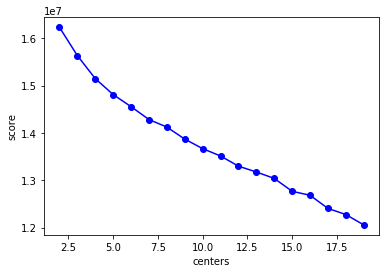

In [96]:

#Investigate the change in within-cluster distance across number of clusters.

plt.plot(clusters_number, scores, linestyle='-', marker='o', color='blue');
plt.xlabel('centers');
plt.ylabel('score');



In [97]:
scores2 = []
clusters_number2 = list(range(17,30))

for c in clusters_number2:
    scores2.append(km_clustering_fun(azdias_pca, c))




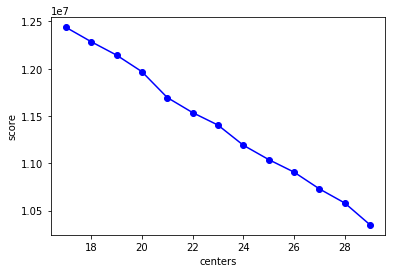

In [98]:
plt.plot(clusters_number2, scores2, linestyle='-', marker='o', color='blue');
plt.xlabel('centers');
plt.ylabel('score');

In [99]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

#done in two different ways

new_score = km_clustering_fun(azdias_pca, 22)

kmeans2 = KMeans(n_clusters = 22)
model = kmeans2.fit(azdias_pca)
azdias_pred = model.predict(azdias_pca)



In [103]:
print(new_score)
print(azdias_pred)

11600239.9496
[16  9 19 ...,  8 15  3]


### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

<font color=green>
    the above plot represents the elbow method to show the different number of clusters,, from the plot it can be observed that at 22 the line changes.. for the the number of clusters that is set is 22.
    </font>

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [104]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
             

In [106]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customer_clean_1= clean_data_2_test(customers)



In [107]:
customer_imputed = pd.DataFrame(imp.fit_transform(customer_clean_1))



In [109]:
#StandardScaler

customers_clean_df_ss = StandardScaler().fit_transform(customer_imputed) #  and transform the data


#kmeansclustering  
#predict_customers = model_general.predict(customers_clean_pca)

In [110]:

# Re-apply PCA to the data while selecting for number of components to retain.

customers_pca = new_pca.fit_transform(customers_clean_df_ss)

In [112]:
new_score = km_clustering_fun(customers_pca, 22)

model = kmeans2.transform(customers_pca)
#customer_pred = model.predict(customers_pca)




5196608.56108


In [116]:
customer_pred = kmeans2.predict(customers_pca)


In [ ]:
#OLD
#customers_predict = kmeans2.predict(customers_clean_pca)

#kmeans3 = KMeans(n_clusters = 22)
#model = kmeans3.fit(customers_clean_pca)
#customers_predict = model.predict(customers_clean_pca)



In [117]:
print(customer_pred)

[11  4  9 ..., 19  5  3]


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.5,1,'General Clusters')

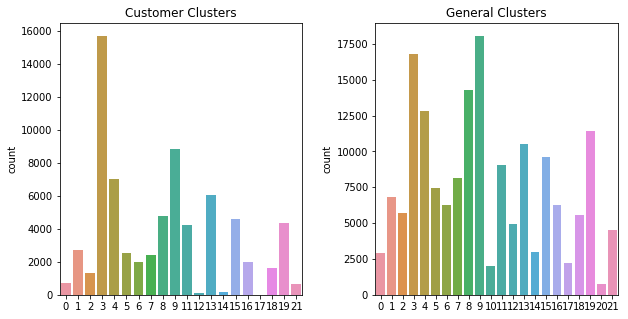

In [119]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (10,5))
figure.subplots_adjust(hspace = 1, wspace=.3)

sns.countplot(customer_pred, ax=axs[0])
axs[0].set_title('Customer Clusters')
sns.countplot(azdias_pred, ax=axs[1])
axs[1].set_title('General Clusters')


In [ ]:
## for customer pop >> the new data


print('end!')

In [120]:
def pc_weights(df, pca, i):
    pc = pd.DataFrame({'attribute': df.columns, 'weight': pca.components_[i-1]})
    print("Most Negative Features:")
    print(pc.sort_values('weight')[:10])
    print("Most Positive Features")
    print(pc.sort_values('weight', ascending = False)[:10])

In [121]:
kmeans2.cluster_centers_[3]

array([-2.29364052, -0.12514778, -0.25130666, -0.58329521, -0.04778073,
       -0.18279536,  0.39364979,  0.06460902, -0.45285733,  2.24965855,
        0.40280166, -1.12884157, -0.14310505,  0.29931118,  0.08103372,
        1.06474087, -0.7575403 , -0.08423379, -0.15782631,  0.1557348 ,
        0.14030439, -0.16308859,  0.14560048, -0.26341665,  0.15943951,
        0.30543323, -0.34471415, -0.75354915,  0.84032006, -0.58379435,
       -0.09220028, -0.19105372, -0.08162513, -0.02195738,  0.02257434,
       -0.0330574 ,  0.15142299,  0.21387191, -0.09345066, -0.37426699,
        0.41435966,  0.2579091 , -0.10168797, -0.0692263 ,  0.10812696,
       -0.01030489,  0.19290043, -0.03688842, -0.00280213, -0.16656838,
       -0.18835909,  0.14745744,  0.01468374,  0.10591879,  0.23535009,
        0.02484271, -0.01401981, -0.19628448, -0.02348572,  0.19502395])

In [129]:
pca_weights_func(new_pca, 5)

print('hello! :) !')


#pca_weights_func(customers_pca, 5) # when i run this one i get errors!

[('OST_WEST_KZ', 0.15513097302470641),
 ('CAMEO_DEUG_2015', 0.12697227597656327),
 ('EWDICHTE', 0.10778581006712501),
 ('INNENSTADT', 0.071096175511427856),
 ('PLZ8_HHZ', 0.026282876488761372),
 ('VERS_TYP', 0.021922442330764277),
 ('SEMIO_REL', 0.021672340503593249),
 ('ANZ_HAUSHALTE_AKTIV', 0.021010870936390431),
 ('KBA05_ANTG3', 0.015899109596122445),
 ('CAMEO_DEU_2015', 0.015218481249667782),
 ('SEMIO_ERL', 0.013806336037659928),
 ('ANZ_PERSONEN', 0.01320397330828813),
 ('KBA05_ANTG1', 0.012907785531156336),
 ('SEMIO_KULT', 0.012641035296618938),
 ('FINANZTYP', 0.012434367633715181),
 ('SEMIO_KRIT', 0.01095187396270619),
 ('ORTSGR_KLS9', 0.010615122812642661),
 ('SEMIO_MAT', 0.0082533940809976503),
 ('KONSUMNAEHE', 0.0080872607702261543),
 ('SEMIO_LUST', 0.0080477094400002343),
 ('SEMIO_VERT', 0.0066412589420975655),
 ('ANREDE_KZ', 0.0059238593290811071),
 ('FINANZ_VORSORGER', 0.0039732874003681092),
 ('PLZ8_ANTG4', 0.0039240029736495848),
 ('GFK_URLAUBERTYP', 0.0015381791011326183

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

<font color=green>
    
for customer population,  cluster 9 is under-represented against in the general (azadias) population, also, 11 and 14 in the customers are underrepresented unlikely in the general population. also, it seems like that clusters 10 and 20 contain no data in the customers population in constrat to the general population. However, the graphs of the two populations are similar with similar altitudes.. 

   </font>

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.